Example. As an example we apply least squares classification to the MNIST data set described in §4.3. The (training) data set contains 60,000 images of size 28 by 28. The number of examples per digit varies between 5421 (for digit five) and 6742 (for digit one). The pixel intensities are scaled to lie between 0 and 1. There is also a separate test set containing 10000 images.

In [102]:
ls mnist/

t10k-images-idx3-ubyte.gz   train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte.gz   train-labels-idx1-ubyte.gz


In [3]:
import struct
import gzip
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# create dictionaries to store the data
train = dict()
test = dict()

In [5]:
def get_images(filename):
    with gzip.GzipFile(Path('mnist', filename), 'rb') as f:
        magic, size, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.frombuffer(f.read(), dtype=np.dtype('B'))
    return images.reshape(size, rows,cols)

In [6]:
train['image'] = get_images('train-images-idx3-ubyte.gz')
test['image'] = get_images('t10k-images-idx3-ubyte.gz')
print(train['image'].shape, test['image'].shape)

(60000, 28, 28) (10000, 28, 28)


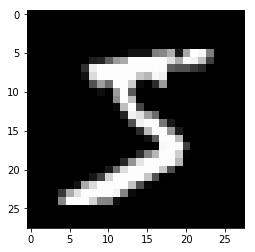

In [7]:
#sanity check that it's loaded in properly
fig, ax = plt.subplots()
_ = ax.imshow(train['image'][0], cmap='gray')

In [8]:
def get_labels(filename):
    with gzip.GzipFile(Path('mnist', filename), 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.dtype('B'))
    return labels

In [9]:
train['label'] = get_labels('train-labels-idx1-ubyte.gz')
test['label'] = get_labels('t10k-labels-idx1-ubyte.gz')
print(train['label'].shape, test['label'].shape)

(60000,) (10000,)


In [10]:
#check that labels are between expected values
np.unique(train['label'])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

For each digit, we can define a Boolean classifier that distinguishes the digit from the other nine digits. Here we will consider classifiers to distinguish the digit zero. In a first experiment, we use the n = 28 × 28 = 784 pixel intensities as features in the least squares classifier (12.1). 

In [92]:
#scales images to 0-1
x = (train['image'].reshape(60000, -1)/255)
#train only on 0, code 0 as +1, >0 as 1
y = (train['label']>0).astype(int)*-2 + 1
# check that y is coded as -1 and 1
np.unique(y)

array([-1,  1])

In [93]:
from sklearn import linear_model as slm

In [94]:
lm = slm.LinearRegression()
lm.fit(x, y)
yhat = lm.predict(x)

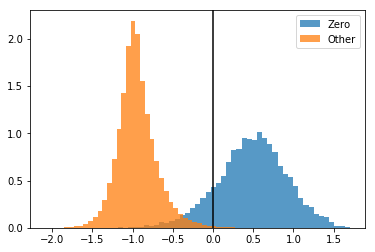

In [101]:
fx = lm.predict(x)
fig, ax = plt.subplots()
_ = ax.hist(fx[y==1], label="Zero", bins=50, density=True, alpha=.75)
_ = ax.hist(fx[y==-1], label="Other", bins=50, density=True, alpha=.75)
_ = ax.legend()
_ = ax.axvline(x=0, color='k')

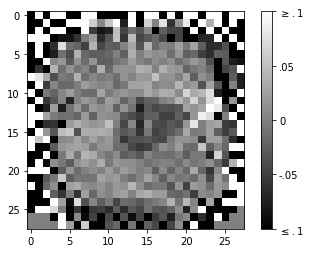

In [91]:
fig, ax = plt.subplots()
im = ax.imshow(lm.coef_.reshape(28,28), cmap="gray", vmin=-.1, vmax=.1)
cb = fig.colorbar(im)
cb.set_ticks([-.1, -.05, 0, .05, .1])
cb.set_ticklabels([r"$\leq.1$", "-.05", "0", ".05", "$\geq.1$"])

In [97]:
yhat = np.sign(yhat)
np.unique(yhat)

array([-1.,  1.])

The performance on the training data set is shown in the following confusion matrix.

|        |$\hat{y}$ = +1|$\hat{y}$ = −1| total|
|:------:|:----------:|:----------:|:----:|
|$y$ = +1  |5165        |758         |5923  |
|$y$ = −1  |179         |53898       |54077 |
|total   |5344        |54656       |60000 |

The error rate is 1.6%. 

In [98]:
tp = ((y==1) & (yhat==1)).sum()
tn = ((y==-1) & (yhat==-1)).sum()
fp = ((y==-1) & (yhat==1)).sum()
fn = ((y==1) & (yhat==-1)).sum()

print(f"{tp:<6} {fn:<6} {tp+fn:<6}")
print(f"{fp:<6} {tn:<6} {fp+tn:<6}")
print(f"{tp+fp:<6} {fn+tn:<6}")

5168   755    5923  
177    53900  54077 
5345   54655 


The performance on the test set is shown in the next confusion matrix.

|        |$\hat{y}$ = +1|$\hat{y}$ = −1| total|
|:------:|:----------:|:----------:|:----:|
|$y$ = +1  |846        |116         |980  |
|$y$ = −1  |42         |8978      |9020 |
|total   |906        |9095       |10000 |


Here too the error rate is 1.6%, giving us some confidence in our classifier.

In [99]:
xt = (test['image'].reshape(10000, -1)/255)
yt = (test['label']>0).astype(int)*-2 + 1

yhatt = np.sign(lmt.predict(xt))

tp = ((yt==1) & (yhatt==1)).sum()
tn = ((yt==-1) & (yhatt==-1)).sum()
fp = ((yt==-1) & (yhatt==1)).sum()
fn = ((yt==1) & (yhatt==-1)).sum()

print(f"{tp:<6} {fn:<6} {tp+fn:<6}")
print(f"{fp:<6} {tn:<6} {fp+tn:<6}")
print(f"{tp+fp:<6} {fn+tn:<6}")

901    79     980   
32     8988   9020  
933    9067  
